In [3]:
import typing
import re
import io
import zipfile

import requests
import pandas as pd
import matplotlib.pyplot as plt

### La descarga de los ficheros

En este notebook vamos a estudiar únicamente los datos de febrero de 2023.
La URL que permite descargar dichos datos es la siguiente:

In [4]:
url = "https://opendata.emtmadrid.es/getattachment/7a88cb04-9007-4520-88c5-a94c71a0b925/trips_23_02_February-csv.aspx"

La función `csv_from_zip` recibe como único argumento un string que represente la URL al fichero ZIP de datos de uso y devuelve un fichero en formato CSV. El tipo del objeto devuelto es `TextIO`. La función  lanzará una excepción de tipo `ConnectionError` en caso de que falle la petición al servidor de la EMT.

In [5]:
def csv_from_zip(url: str) -> typing.TextIO:
    try:
        r = requests.get(url)
        r.raise_for_status()
        bytes = io.BytesIO(r.content)
        zfile = zipfile.ZipFile(bytes)
        with zfile.open('trips_23_02_February.csv') as f:
            contents = f.read()
            contentstr = contents.decode('utf-8')
            fstr = io.StringIO(contentstr)
        return fstr
    except Exception as e:
        raise ConnectionError(e)

La función `get_data` recibe como único argumento un fichero csv y devuelve un objeto de tipo DataFrame con las siguientes restricciones:
* El índice del dataframe debe ser a fecha en la que tuvo lugar el viaje (usa el argumento `index_col`).
* Todas las fechas que aparecen en los datos ha de tener tipo `datetime` (usa el argumento 'parse_dates`).
* De todas las columnas que hay en el fichero, solo guardamos las que nos interesan:

   ```
     [ 'idBike', 'fleet', 'trip_minutes', 'geolocation_unlock', 'address_unlock', 'unlock_date', 'locktype',
     'unlocktype', 'geolocation_lock', 'address_lock', 'lock_date', 'station_unlock', 'unlock_station_name',
     'station_lock', 'lock_station_name']
   ```

In [6]:
def get_data(csv_file):
    columns = [
        'idBike', 'fleet', 'trip_minutes', 'geolocation_unlock', 'address_unlock', 'unlock_date', 'locktype',
        'unlocktype', 'geolocation_lock', 'address_lock', 'lock_date', 'station_unlock', 'unlock_station_name',
        'station_lock', 'lock_station_name'
    ]
    
    df = pd.read_csv(
        csv_file,
        sep=';',
        usecols=columns,
        index_col='unlock_date',
        parse_dates=['unlock_date', 'lock_date']
    )
    
    return df

La función `clean` borra las filas con todos sus valores `NaN` de un dataframe recibido como argumento. Además, cambia el tipo de las columnas `idBike`, `fleet`, `station_lock` y `station_unlock` a tipo string. La función modifica el dataframe y no devuelve nada. Si la columna no se encuentra entre las columnas del dataframe, la función no hace nada.

In [7]:
def clean(df):

    df.dropna(how='all', inplace=True)
    
    for column_name in ['fleet', 'idBike', 'station_lock', 'station_unlock']:
        try:
            df[column_name] = df[column_name].map(lambda x: str(int(x)) if pd.notna(x) and isinstance(x, (int, float)) else re.sub(r'[a-zA-Z]', '', str(x)) if pd.notna(x) else x)
        except:
            continue
    
    return df

In [8]:
usos = clean(get_data(csv_from_zip(url)))
usos.head()

,idBike,fleet,trip_minutes,geolocation_unlock,address_unlock,locktype,unlocktype,geolocation_lock,address_lock,lock_date,station_unlock,unlock_station_name,station_lock,lock_station_name
unlock_date,,,,,,,,,,,,,,
2023-02-01 00:00:10,7337,1,5.52,"{'type': 'Point', 'coordinates': [-3.6956178, ...",'Calle Jesús nº 1',STATION,STATION,"{'type': 'Point', 'coordinates': [-3.7088337, ...",'Plaza de la Cebada nº 16 ',2023-02-01 00:05:41,31,27 - Huertas,43,39 - Plaza de la Cebada
2023-02-01 00:00:25,5098,1,0.32,"{'type': 'Point', 'coordinates': [-3.7022591, ...",'Glorieta de Embajadores nº 2',STATION,STATION,"{'type': 'Point', 'coordinates': [-3.7022591, ...",'Glorieta de Embajadores nº 2',2023-02-01 00:00:44,52,48 - Embajadores 2,52,48 - Embajadores 2
2023-02-01 00:00:36,6519,1,0.27,"{'type': 'Point', 'coordinates': [-3.6894193, ...",'Calle Antonio Maura nº 15',STATION,STATION,"{'type': 'Point', 'coordinates': [-3.6894193, ...",'Calle Antonio Maura nº 15',2023-02-01 00:00:52,69,65 - Antonio Maura,69,65 - Antonio Maura
2023-02-01 00:00:53,2551,1,8.58,"{'type': 'Point', 'coordinates': [-3.7022591, ...",'Glorieta de Embajadores nº 2',STATION,STATION,"{'type': 'Point', 'coordinates': [-3.6991147, ...",'Calle Atocha nº 54',2023-02-01 00:09:28,52,48 - Embajadores 2,45,41 - Antón Martín
2023-02-01 00:00:57,6519,1,0.20,"{'type': 'Point', 'coordinates': [-3.6894193, ...",'Calle Antonio Maura nº 15',STATION,STATION,"{'type': 'Point', 'coordinates': [-3.6894193, ...",'Calle Antonio Maura nº 15',2023-02-01 00:01:09,69,65 - Antonio Maura,69,65 - Antonio Maura


## Consultas

Las siguientes consultas se realizarán con el dataframe `usos` creado en los apartados anteriores.

### C1

¿Cuántas bicicletas han sido desbloqueadas de una estación y no se bloquean en ninguna?

In [9]:
filtrado = (usos['unlocktype'] == 'STATION') & (usos['locktype'] == 'FREE')
usos[filtrado].shape[0]

168

### C2

Seleccionar solo las bicicletas del tipo de flota '1' . El nuevo dataframe se ha de llamar `regular_fleet`.

In [11]:
mask_fleet_1 = usos['fleet'] == '1'
regular_fleet = usos[mask_fleet_1]
regular_fleet['fleet'].unique()

array(['1'], dtype=object)

### C3

Crea una función llamada `day_time` para calcular las horas totales de uso de bicicletas por día del mes.
La función recibe un dataframe y devuelve una Serie donde el índice es la fecha y el valor es el número de horas.

Prueba la función anterior con el dataframe  `usos`.

__Opcional:__ Dibuja un diagrama de barras con el resultado de la función `day_time` sobre el dataframe `usos`. Utiliza el módulo `matplotlib.pyplot`.

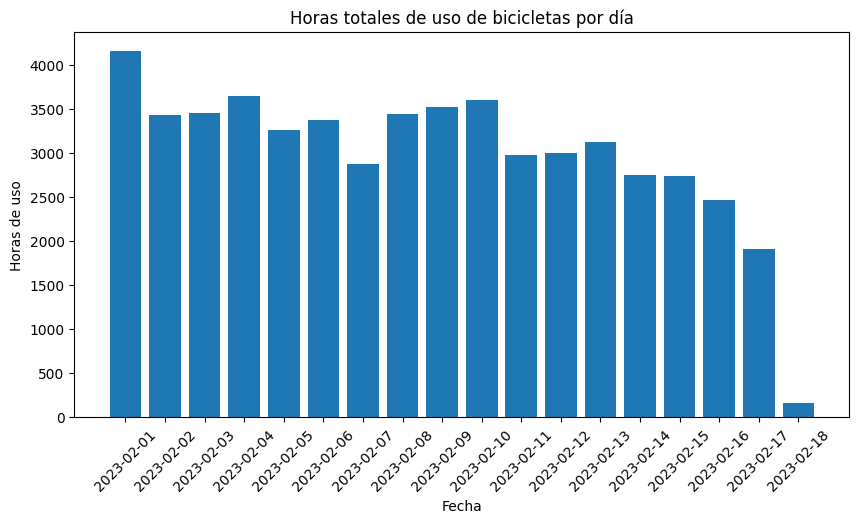

In [12]:
import pandas as pd

def day_time(df):
    df = df.copy()
    df["date"] = df.index.date
    daily_hours = df.groupby("date")["trip_minutes"].sum() / 60
    return daily_hours

test = day_time(usos)

plt.figure(figsize=(10, 5))
plt.bar(test.index.astype(str), test.values)
plt.xlabel("Fecha")
plt.ylabel("Horas de uso")
plt.title("Horas totales de uso de bicicletas por día")
plt.xticks(rotation=45)
plt.show()

### C4

Crea una función llamada `weekday_time` para calcular las horas totales de uso de bicicletas por día de la semana. La función recibe un dataframe y devuelve una Serie donde el índice es el día de la semana (L, M, X, J, V, S, D) y el valor es el número de horas.

Prueba la función anterior con el dataframe usos.



weekday
L     6494.488500
M     5626.440667
X    10349.659667
J     9412.645333
V     8958.274000
S     6781.029667
D     6267.562167
Name: trip_minutes, dtype: float64

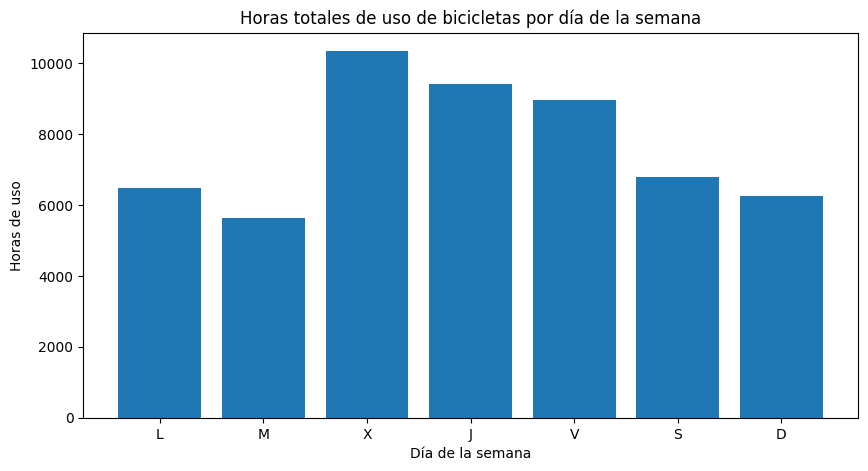

In [13]:
def weekday_time(df):
    df = df.copy()
    days_map = {0: 'L', 1: 'M', 2: 'X', 3: 'J', 4: 'V', 5: 'S', 6: 'D'}
    df["weekday"] = df.index.dayofweek.map(days_map)
    weekday_hours = df.groupby("weekday")["trip_minutes"].sum() / 60
    return weekday_hours

test = weekday_time(usos).reindex(['L', 'M', 'X', 'J', 'V', 'S', 'D'])
display(test)

plt.figure(figsize=(10, 5))
plt.bar(test.index, test.values)
plt.xlabel("Día de la semana")
plt.ylabel("Horas de uso")
plt.title("Horas totales de uso de bicicletas por día de la semana")
plt.show()

### C5

Crea una función llamada `total_usage_day` para calcular el número total de usos de bicicletas por día del mes. La función recibe un dataframe y devuelve una Serie donde el índice es la fecha y el valor es el número de usos.

Prueba la función anterior con el dataframe usos.



date
2023-02-01    11442
2023-02-02    11069
2023-02-03    10166
2023-02-04     8903
2023-02-05     8026
2023-02-06    10118
2023-02-07     8986
2023-02-08    10576
2023-02-09    10814
2023-02-10    10579
2023-02-11     8383
2023-02-12     7801
2023-02-13     9802
2023-02-14    10341
2023-02-15    10766
2023-02-16     9684
2023-02-17    10067
2023-02-18      971
dtype: int64

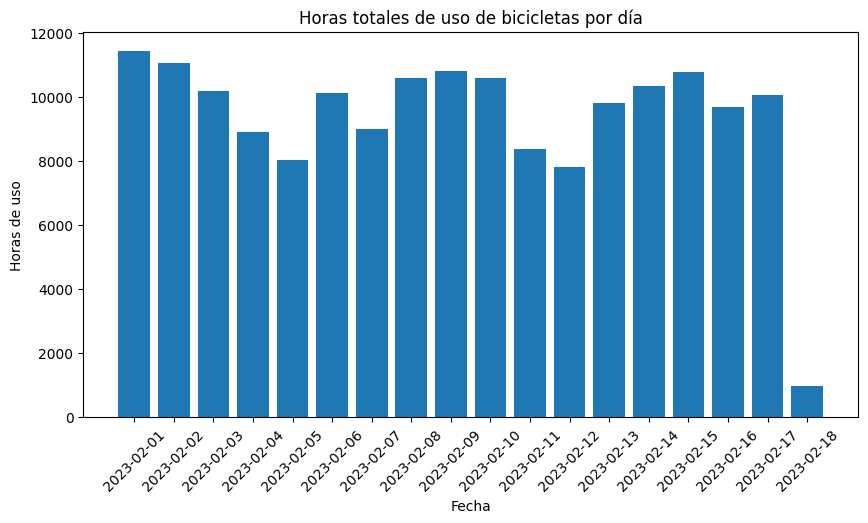

In [14]:
import pandas as pd

def total_usage_day(df):
    df = df.copy()
    df["date"] = df.index.date
    daily_total_uses = df.groupby("date").size()
    return daily_total_uses

test = total_usage_day(usos)

display(test)

plt.figure(figsize=(10, 5))
plt.bar(test.index.astype(str), test.values)
plt.xlabel("Fecha")
plt.ylabel("Horas de uso")
plt.title("Horas totales de uso de bicicletas por día")
plt.xticks(rotation=45)
plt.show()

### C6

Calcular el total de usos por fecha y estación de desbloqueo. Como la fecha está en el índice y la estación de desbloqueo es una columna, lo mejor es agrupar por la columna `station_unlock` y  un objeto `Grouper` de frecuencia diaria (1D).

A continuación, se muestra un ejemplo del funcionamiento de la función Grouper de pandas:
```
>>> df
             ID  Price
2000-01-02   0     10
2000-01-02   1     20
2000-01-09   2     30
2000-01-16   3     40

# Grouper con frecuencia semanal (1W)
>>> df.groupby(pd.Grouper(freq="1W")).mean()
               ID  Price

2000-01-02    0.5   15.0
2000-01-09    2.0   30.0
2000-01-16    3.0   40.0
```

In [15]:
def total_usage_date_station(df):
    df = df.copy()
        
    daily_total_uses = df.groupby([pd.Grouper(freq="1D"), "station_unlock"]).size().reset_index(name="total_uses")

    return daily_total_uses.set_index('unlock_date')

test = total_usage_date_station(usos)

display(test)

,station_unlock,total_uses
unlock_date,,
2023-02-01,1,31
2023-02-01,10,33
2023-02-01,100,31
2023-02-01,101,23
2023-02-01,102,57
...,...,...
2023-02-18,94,6
2023-02-18,95,3
2023-02-18,96,1


### C7

Se quiere averiguar la dirección de las estaciones de desbloqueo que a lo largo del mes han tenido un mayor número de viajes. Crear una función llamada `most_popular_stations` que calcule dicho dato. El argumento de la función es un dataframe y devuelve un conjunto con la dirección de las estaciones.



In [16]:
def most_popular_stations(df):
    df = df.copy()
    
    counts = df.groupby(["station_unlock", "address_unlock"]).size()
    
    max_uses = counts.max()
    
    most_popular = counts[counts == max_uses].index.get_level_values("address_unlock")
    
    return set(most_popular)

most_popular_stations(usos)

{"'Plaza de la Cebada nº 16 '"}

### C8

Se quiere averiguar el  número de usos de las estaciones de desbloqueo que a lo largo del mes ha tenido un mayor número de viajes. Crear una función llamada `usage_from_most_popular_station` que calcule dicho dato. El argumento de la función es un dataframe y devuelve un entero.

In [17]:
def usage_from_most_popular_station(df):
    df = df.copy()
    
    station_counts = df.groupby("station_unlock").size()
    
    max_usage = station_counts.max()
    
    return int(max_usage)

usage_from_most_popular_station(usos)

2189

### ETAPA 3: Probando el paquete creado

Instalamos el paquete en el environment en el corre este notebook.

In [18]:
pip install --force-reinstall bicimad-1.0.0-py3-none-any.whl

Processing ./bicimad-1.0.0-py3-none-any.whl
  Using cached pandas-2.2.3-cp312-cp312-macosx_11_0_arm64.whl.metadata (89 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached numpy-2.2.4-cp312-cp312-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached charset_normalizer-3.4.1-cp312-cp312-macosx_10_13_universal2.whl.metadata (35 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached urllib3-2.3.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached certifi-2025.1.31-py3-none-any.whl.metadata (2.5 kB)
  Using cached six-1.17.0-py2.py3-none-any.whl.metadata (1.7 kB)
Using cached pandas-2.2.3-cp312-cp312-macosx_11_0_arm64.whl (11.4 MB)
Using cached requests-2.32.3-py3-none-any.whl (64 kB)
Using cached certifi-2025.1.31-py3-none-a

In [19]:
# creación de un objeto bicimad
from bicimad import BiciMad

In [20]:
b = BiciMad(5, 22)

/Users/orr21/Documents/UCM/Master/Python/0_Tareas/Entregable/bicimad/bicimad.py:40: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(


In [21]:
# preguntamos por el tamaño de los datos y los usos de la estación 
# con más usos en Mayo de 2022
assert(len(b.data) == 955868)
assert(b.usage_from_most_popular_station() == 3553)
# esta celda no debe producir resultados

In [22]:
b.resume()

year                                                 22
month                                                 5
total_uses                                       955868
total_time                                    160258.01
most_popular_station      {'Plaza de la Cebada nº 16 '}
uses_from_most_popular                             3553
dtype: object

### Observaciones

Para la columna station_unlock la limpieza debe ser bastante profunda. No es tan trivial como pasar de float a str, ya que, en ocaciones los valores de la columna ya están en entero. Entonces habría que pasar de string a entero, y después a float. Pero, en los datos del mundo real, nada es así de sencillo. Ocurre que hay filas donde los valores de la estación y un anclaje de bici (por poner un ejemplo), los que, asumire que pertenecen a la misma estación, pero son anclajes distintos. Entonces a estos valores les tendría que eliminar la letra y después convertirlos.

```python
def clean(self) -> None:
    '''
    Cleans the dataset in-place by:
    - Removing fully empty rows
    - Converting specified columns to string type
    :returns: None (modifies the internal DataFrame)
    Examples
    --------
    >>> b = BiciMad(3, 21)
    >>> b.clean()
    >>> b.data.isnull().all(axis=1).any()
    False
    '''

    self.__data.dropna(how='all', inplace=True)
    
    for col in ['fleet', 'idBike', 'station_lock', 'station_unlock']:
        self.__data[col] = self.__data[col].map(lambda x: str(int(x)) if pd.notna(x) and isinstance(x, (int, float)) else re.sub(r'[a-zA-Z]', '', str(x)) if pd.notna(x) else x)
```

De ahí que la función clean que desarrollé para la clase bicimad sea tan exhaustiva en búsqueda de estos casos particulares, pero mantenga su funcionamiento en casos normativos.

Ejemplo de datos para Mayo de 2022 donde ocurre este caso particular:

In [23]:
b = BiciMad(5, 22)

/Users/orr21/Documents/UCM/Master/Python/0_Tareas/Entregable/bicimad/bicimad.py:40: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(


In [24]:
multi_station_mask = b.data['station_unlock'].str.contains('111').fillna(False)
float_station_mask = b.data['station_unlock'] == 111.0
b.data[ multi_station_mask | float_station_mask]['station_unlock'].unique()

/var/folders/9t/l_ntghhj16j5hvl_28rzrds80000gp/T/ipykernel_13030/3730946004.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  multi_station_mask = b.data['station_unlock'].str.contains('111').fillna(False)


array(['111', 111.0, '111b', '111a'], dtype=object)

Esto parece ocurrir de Febrero de 2022 hasta Junio de 2022